In [27]:
%load_ext autoreload
%autoreload 2

import __confing
__confing.change_to_root_folder()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory: c:\Users\Leo\OneDrive\Escritorio\Final Proyect


In [117]:
import pandas as pd

from src import value_filler as vs
from src import feature_selection as fs
from src import data_procces as dp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from src import evaluation
from imblearn.over_sampling import SMOTE

In [53]:
df=pd.read_csv(r'data\waves\all_waves.csv')
target='rahosp1y'

In [54]:
# Dropea las filas que cumplan las condiciones
df = df.drop(['rahspnit1y','wave','rahhidnp'], axis=1)

df = df.dropna(subset=[target])

porcentaje_nulos = df.isnull().sum(axis=1) / len(df.columns)
df = df[(df['rahosp1y'] != 0) | (porcentaje_nulos <= 0.4)]

In [55]:
df = fs.fast_fill(df)

In [118]:
l1=fs.get_corr_columns(df,target,True)
l2=fs.get_corr_columns(df,target,False)
l3=l1+l2

df_f = df[l3]
df_f[target] = df[target]
# df_f['cpindex'] = df['cpindex']

C:\Users\Leo\AppData\Local\Temp\ipykernel_6240\494790093.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f[target] = df[target]


In [132]:
df_f['cpindex'] = df['cpindex']

C:\Users\Leo\AppData\Local\Temp\ipykernel_6240\2140277769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['cpindex'] = df['cpindex']


In [133]:
# df da mejor q x porq no elimina col relacionadas
x, y = dp.equalize_class_imbalance(df_f,target)

rahosp1y
0.0    12870
1.0     9193
Name: count, dtype: int64


In [134]:
smote = SMOTE(random_state=42)
x, y = smote.fit_resample(x, y)

y.value_counts()

rahosp1y
0.0    12870
1.0    12870
Name: count, dtype: int64

In [135]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [136]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

# lightgbm

In [137]:
import lightgbm as lgb

params = {
    'num_leaves': 37,
    'learning_rate': 0.015822147370206017,
    'feature_fraction': 0.27675906087193586,
    'bagging_fraction': 0.7771549814223269,
    'bagging_freq': 4,
    'min_child_samples': 8, 
}

model = lgb.LGBMClassifier(**params)

[LightGBM] [Warning] feature_fraction is set=0.27675906087193586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27675906087193586
[LightGBM] [Warning] bagging_fraction is set=0.7771549814223269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7771549814223269
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


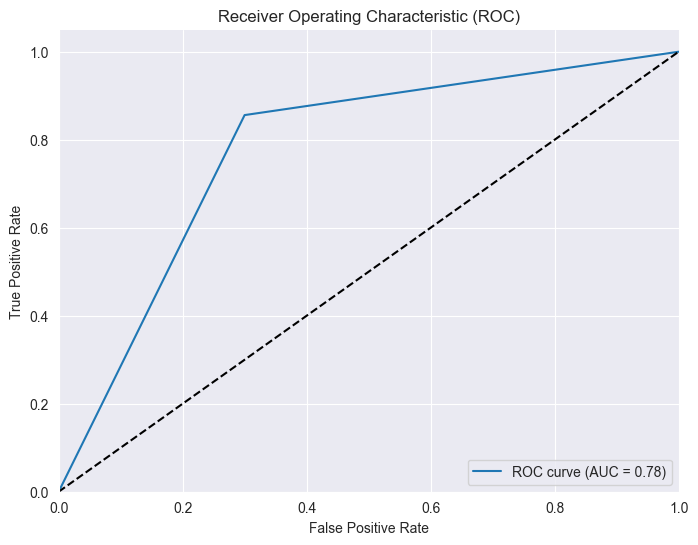

In [138]:
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

evaluation.plot_roc(y_pred,y_test)

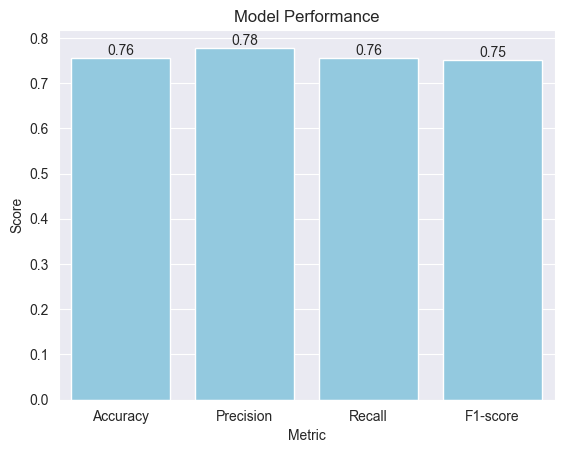

In [139]:
evaluation.get_model_performance(y_pred,y_test)

# xgboost

In [140]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report,mean_squared_error
import optuna

In [151]:
best_params={
    'max_depth': 3,
    'learning_rate': 0.21437737019643555,
    'n_estimators': 383,
    'min_child_weight': 1,
    'gamma': 1.7231253295851337e-07,
    'subsample': 0.9074151372299069,
    'colsample_bytree': 0.9210455551716151,
    'reg_alpha': 1.8101876780247352e-07,
    'reg_lambda': 5.689166590043403e-08
}

# Entrenar el modelo final con los mejores parámetros
best_model = XGBClassifier(**best_params)
best_model.fit(x_train, y_train)

# Predecir sobre el conjunto de prueba utilizando el modelo final
y_pred = best_model.predict(x_test)
final_rmse = mean_squared_error(y_test, y_pred, squared=False)

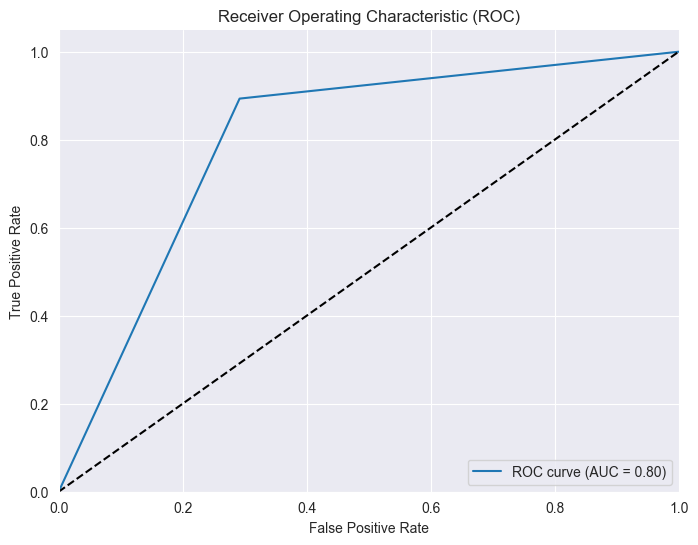

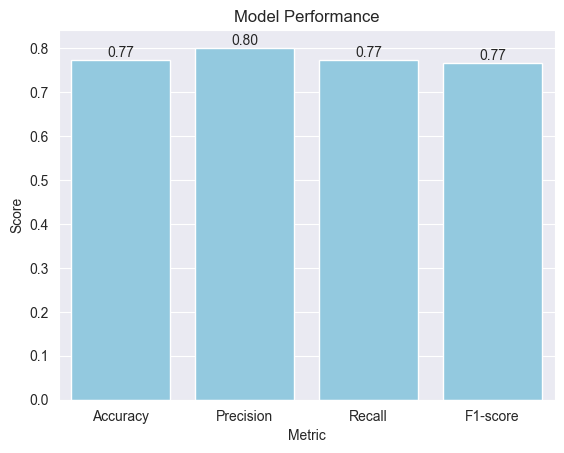

In [152]:
evaluation.plot_roc(y_pred,y_test)
evaluation.get_model_performance(y_pred,y_test)

In [ ]:
# def objective(trial):
#     """Define the objective function"""

#     params = {
#         'max_depth': trial.suggest_int('max_depth', 1, 9),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
#         'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
#         'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
#         'eval_metric': 'mlogloss',
#         'use_label_encoder': False
#     }

#     # Fit the model
#     optuna_model = XGBClassifier(**params)
#     optuna_model.fit(x_train, y_train)

#     # Make predictions
#     y_pred = optuna_model.predict(x_test)

#     # Evaluate predictions
#     accuracy = accuracy_score(y_test, y_pred)
#     return accuracy

# # Crear el estudio Optuna y optimizar los parámetros
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Obtener los mejores parámetros y su valor de error mínimo
# best_params = study.best_params
# best_rmse = study.best_value